# Long Short Term Memory
## A simple guide using keras library 

In this tutorial we will use supernova simulations to train a Recurren Neural Network using LSTM units.

In [1]:
import h5py
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import pandas as pd

2022-07-27 20:40:05.439977: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-27 20:40:05.439999: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Load data

In [2]:
filename = './data/supernovae.hdf5'
f = h5py.File(filename, 'r')
light_curves = f['curves'][()]
labels       = f['labels'][()]
ids          = f['sne_id'][()]

I = [1,3,32,33]
labels_new = np.array([0 if l in I else 1 for l in labels ])
multi_class = {1: 0, 2:1, 3:2, 21:3, 22:4, 23:5, 32:6, 33:7}
labels     = np.array([multi_class[l] for l in labels])

<img src="./img/sne_types.png" alt="Girl in a jacket" width="350" height="400"> 

Supernova classes are very unbalanced. A faster way is to group by parent class; It means that we are going to transform a multiclass problem into a binary one.

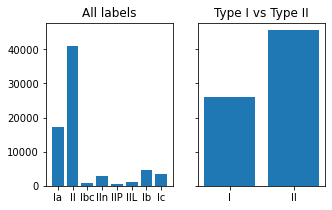

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(5,3), sharey=True)

# (labels, class names, figure title)
multi_tuple = (labels, ['Ia', 'II', 'Ibc', 'IIn', 'IIP', 'IIL', 'Ib', 'Ic'], 'All labels')
binar_tuple = (labels_new, ['I', 'II'], 'Type I vs Type II')

for index, (y_vector, cls_names, title) in enumerate([multi_tuple, binar_tuple]):
    values, counts = np.unique(y_vector, return_counts=True)
    x_range = np.arange(len(values))
    axes[index].bar(x_range,counts)
    axes[index].set_title(title)
    axes[index].set_xticks(x_range)
    axes[index].set_xticklabels(cls_names)
    
plt.show()

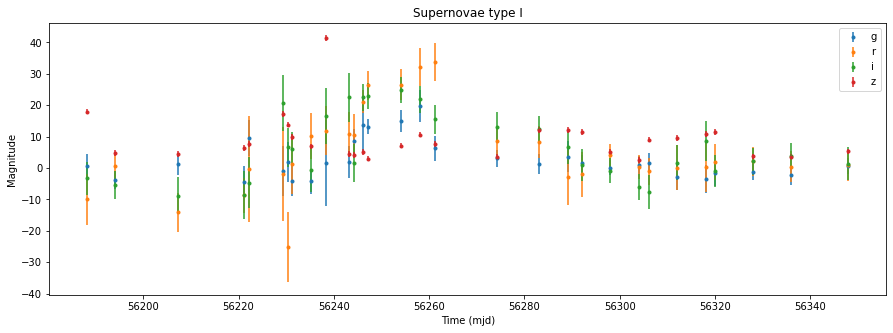

In [4]:
selected = light_curves[labels_new == 0][0]
plt.figure(figsize=(15,5))

for i, passband in enumerate(['g', 'r', 'i', 'z']):
    plt.errorbar(selected[:,0], 
                 selected[:,i+1], 
                 yerr=selected[:,i+5], 
                 label=passband, 
                 fmt='.')

plt.legend()
plt.xlabel('Time (mjd)')
plt.ylabel('Magnitude')
plt.title('Supernovae type I')
plt.show()


## Data preprocessing using tf.Data

In [5]:
INP_DIM = 9 # Number of attributes e.g., mjd, magnitudes, errors...
NUM_CLS = len(np.unique(labels_new))
BATCH_SIZE = 128 # Training batch size

In [6]:
def create_generator(list_of_arrays, labels):
    for i, j in zip(list_of_arrays, labels):
        yield {'lightcurve': i,
               'label'     : int(j),
               'mask'      : np.ones(i.shape[0])}

In [7]:
def preprocess(input_dict):
    lc_means = tf.reduce_mean(input_dict['lightcurve'], 0)
    lc_std   = tf.math.reduce_std(input_dict['lightcurve'], 0)
    light_curve = tf.math.divide_no_nan(input_dict['lightcurve'] - tf.expand_dims(lc_means, 0), lc_std)
    
#     light_curve = input_dict['lightcurve'] - tf.expand_dims(lc_means, 0)
    
    cat_label   = tf.one_hot(input_dict['label'], NUM_CLS)
    bool_mask   = tf.cast(input_dict['mask'], tf.bool)
    return (light_curve, bool_mask), cat_label

In [8]:
def create_dataset(light_curves, labels):
    dataset = tf.data.Dataset.from_generator(lambda: create_generator(light_curves, labels),
                                             output_types= {'lightcurve':tf.float32,
                                                            'label':tf.int32,
                                                            'mask':tf.int32},
                                             output_shapes={'lightcurve':(None, INP_DIM),
                                                            'label':(),
                                                            'mask':(None)})
    dataset = dataset.map(preprocess)
    dataset = dataset.shuffle(1000) # shuffling in chunks of 1000 objects 
    dataset = dataset.padded_batch(BATCH_SIZE, padded_shapes=(([None, INP_DIM], [None]), [NUM_CLS]))
    return dataset

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
x_train, x_rest, \
y_train, y_rest = train_test_split(light_curves, labels_new, test_size=0.5, random_state=42)

x_val, x_test, \
y_val, y_test = train_test_split(x_rest, y_rest, test_size=0.5, random_state=42)

In [11]:
y_train

array([1, 1, 0, ..., 1, 1, 1])

In [12]:
train_batches = create_dataset(x_train, y_train) 
valid_batches = create_dataset(x_val, y_val)
test_batches  = create_dataset(x_test, y_test)

2022-07-27 20:40:08.073308: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-27 20:40:08.073335: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-27 20:40:08.073351: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (appa): /proc/driver/nvidia/version does not exist
2022-07-27 20:40:08.073609: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
for (x,m), y in valid_batches:
    print(x.shape)
    print(m.shape)
    print(y.shape)
    break

(128, 30, 9)
(128, 30)
(128, 2)


## Long Short Term Memory

Using ```Sequential()``` class from *Keras Library* we can stack several layers. In this case, we will use recurrent and dense layer for *the middle learning* and dense activated layer for the output. Remember that the output should have the same dimension as number of classes are considered.<br><br>A graphical representation is shown bellow 

<img src="./img/archi.png" alt="Girl in a jacket" width="700" height="400"> 

In [14]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, LSTM, Dropout, Input, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [15]:
# Params 
n_neurons    = 16  # Neurons in each gate of LSTM
dropout_prob = 0.2 # Fraction of the units to drop 

In [16]:
lc_placeholder   = Input(shape=(None, INP_DIM), dtype=tf.float32)
mask_placeholder = Input(shape=(None,), dtype=tf.bool)
inputs = (lc_placeholder, mask_placeholder)

x = LSTM(n_neurons, return_sequences=True, dropout=dropout_prob)(inputs[0], mask=inputs[1])
x = LSTM(n_neurons, dropout=dropout_prob)(x, mask=inputs[1])
x = Dense(n_neurons, activation='relu')(x)
predictions = Dense(NUM_CLS, activation='softmax')(x)

model = Model(inputs=[inputs], outputs=predictions)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 9)]    0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 lstm (LSTM)                    (None, None, 16)     1664        ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 16)           2112        ['lstm[0][0]',               

In [17]:
history = model.fit(x=train_batches, 
                    epochs=3,
                    validation_data=valid_batches,
                    callbacks = [EarlyStopping(patience=5)])

Epoch 1/3
280/280 [==============================] - 22s 60ms/step - loss: 0.4891 - acc: 0.7595 - val_loss: 0.3158 - val_acc: 0.8699
Epoch 2/3
280/280 [==============================] - 14s 51ms/step - loss: 0.3290 - acc: 0.8592 - val_loss: 0.2711 - val_acc: 0.8922
Epoch 3/3
280/280 [==============================] - 16s 58ms/step - loss: 0.3086 - acc: 0.8722 - val_loss: 0.2575 - val_acc: 0.8980


In [18]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

y_probas = model.predict(test_batches)
y_pred   = np.argmax(y_probas, axis=1)

y_test   = np.concatenate([y for _, y in test_batches], 0)
y_true   = np.argmax(y_test, axis=1)

acc_test = accuracy_score(y_true, y_pred)
f1_score = f1_score(y_true, y_pred, average='macro') 
print('Accuracy:{}\nF1:{}'.format(acc_test, f1_score))

Accuracy:0.5366057966158485
F1:0.5041250329209994


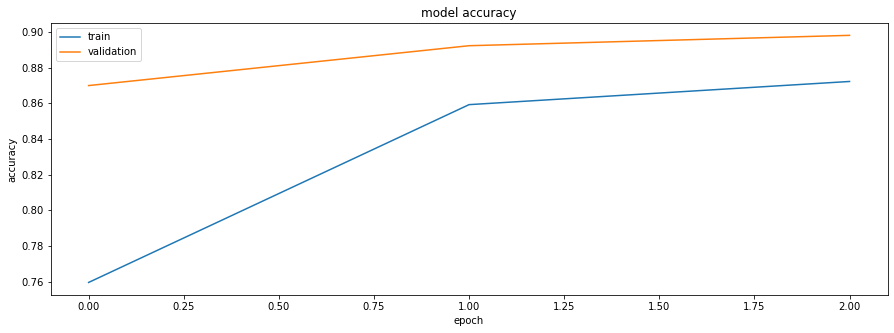

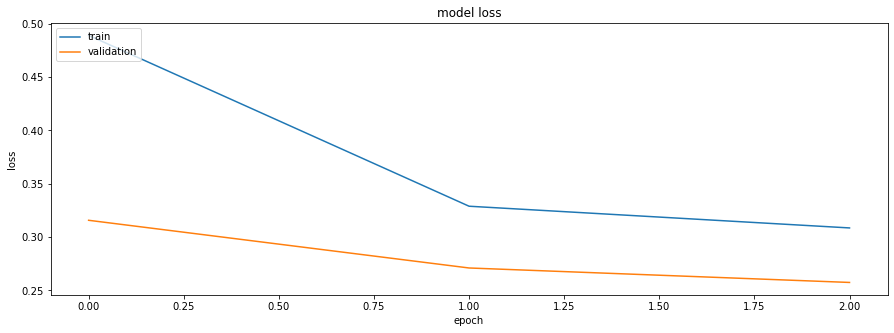

In [19]:
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

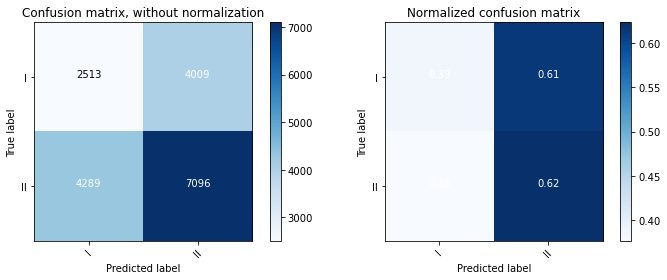

In [20]:
from sklearn.metrics import confusion_matrix
from visual import plot_confusion_matrix
class_names = ['I', 'II']
cnf_matrix = confusion_matrix(y_true, y_pred)
# Plot non-normalized confusion matrix
plt.figure(figsize=(10,4))
plt.subplot(121)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(122)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')